In [9]:
import gdown
import pims
import torch as tr
import yaml
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import shutil
from omegaconf import OmegaConf
import os

os.environ["VRE_DEVICE"] = device = "cuda" if tr.cuda.is_available() else "cpu"

from vre import VRE
from vre.representations import build_representations_from_cfg
from vre.utils import get_project_root, image_read, collage_fn, image_write

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
video = pims.Video(get_project_root() / "resources/test_video.mp4")
video.file = get_project_root() / "resources/test_video.mp4"
print(video)

<FramesSequenceND>
Axes: 3
Axis 'x' size: 1280
Axis 'y' size: 720
Axis 't' size: 5395
Pixel Datatype: uint8


In [11]:
all_representations_dict = yaml.safe_load(f"""
rgb:
  type: default/rgb
  dependencies: []
  parameters: {{}}

depth_dpt:
  type: depth/dpt
  dependencies: []
  parameters: {{}}
  device: {device}

normals_svd(depth_dpt):
  type: normals/depth-svd
  dependencies: [depth_dpt]
  parameters:
    sensor_fov: 75
    sensor_width: 3840
    sensor_height: 2160
    window_size: 11

depth_marigold:
  type: depth/marigold
  dependencies: []
  parameters:
    variant: marigold-lcm-v1-0
    denoising_steps: 4
    ensemble_size: 1
    processing_resolution: 768
  device: {device}

normals_svd(depth_marigold):
  type: normals/depth-svd
  dependencies: [depth_marigold]
  parameters:
    sensor_fov: 75
    sensor_width: 3840
    sensor_height: 2160
    window_size: 11

""")
# all_representations_dict = OmegaConf.load(open(Path.cwd() / "cfg.yaml", "r")).representations
representations = build_representations_from_cfg(all_representations_dict)
print(representations)

[2024-10-12T18:56:40 VRE-DEBUG] Doing topological sort... (build_representations.py:build_representations_from_cfg:96)
[2024-10-12T18:56:40 VRE-INFO] Building 'depth/marigold' (vre name: depth_marigold) (build_representations.py:build_representation_from_cfg:74)
[2024-10-12T18:56:40 VRE-INFO] Explicit device provided: cuda. This device will be used at vre.run() (build_representations.py:build_representation_from_cfg:81)
[2024-10-12T18:56:40 VRE-INFO] Building 'depth/dpt' (vre name: depth_dpt) (build_representations.py:build_representation_from_cfg:74)
[2024-10-12T18:56:40 VRE-INFO] Explicit device provided: cuda. This device will be used at vre.run() (build_representations.py:build_representation_from_cfg:81)
[2024-10-12T18:56:40 VRE-INFO] Building 'default/rgb' (vre name: rgb) (build_representations.py:build_representation_from_cfg:74)
[2024-10-12T18:56:40 VRE-INFO] Building 'normals/depth-svd' (vre name: normals_svd(depth_marigold)) (build_representations.py:build_representation_from

{'depth_marigold': [Representation] Marigold(depth_marigold), 'depth_dpt': [Representation] DepthDpt(depth_dpt), 'rgb': [Representation] RGB(rgb), 'normals_svd(depth_marigold)': [Representation] DepthNormalsSVD(normals_svd(depth_marigold)), 'normals_svd(depth_dpt)': [Representation] DepthNormalsSVD(normals_svd(depth_dpt))}


In [12]:
vre = VRE(video, representations)
output_dir = Path.cwd() / "here"
shutil.rmtree(output_dir, ignore_errors=True)
print(vre)
start_frame = np.random.randint(0, len(video) - 5)
end_frame = start_frame + 1
res = vre.run(output_dir=output_dir, start_frame=start_frame, end_frame=end_frame, batch_size=1,
              output_dir_exists_mode="skip_computed")
display(res)

[2024-10-12T18:56:40 VRE-INFO] Adding file handler to this logger (VRE) to '/home/mihai/code/ml/video-representations-extractor/logs/logs-2024-10-12T15:56:40.738.txt' (loggez.py:_add_file_handler:61)
[2024-10-12T18:56:40 VRE-INFO] [VRERuntimeArgs]
- Video path: '/home/mihai/code/ml/video-representations-extractor/resources/test_video.mp4'
- Output dir: '/home/mihai/code/ml/video-representations-extractor/examples/notebooks/here')
- Representations (5): depth_marigold, depth_dpt, rgb, normals_svd(depth_marigold), normals_svd(depth_dpt)
- Video shape: (5395, 720, 1280, 3) (FPS: 29.97)
- Output frames (1): [81 : 81]
- Output shape: (720, 1280)
- Batch size: 1
- Export npy: True
- Export png: True
- Exception mode: 'stop_execution'
- Output dir exists mode: 'skip_computed'
- Thread pool workers for storing data (0 = using main thread): 0
- Load from disk if computed: True
 (vre_runtime_args.py:__init__:77)
[2024-10-12T18:56:40 VRE-DEBUG] [DataStorer] Set up with 0 threads. (data_storer.py:

VRE (5 representations). Video: '/home/mihai/code/ml/video-representations-extractor/resources/test_video.mp4' ((5395, 720, 1280, 3))


[2024-10-12T18:56:45 VRE-DEBUG] Loading weights from '/home/mihai/code/ml/video-representations-extractor/resources/weights/depth/marigold/vae.pt' (resources.py:vre_load_weights:73)
[2024-10-12T18:56:45 VRE-DEBUG] Loading weights from '/home/mihai/code/ml/video-representations-extractor/resources/weights/depth/marigold/marigold-lcm-v1-0_unet.pt' (resources.py:vre_load_weights:73)
[VRE] depth_marigold bs=1: 100%|██████████| 1/1 [00:03<00:00,  3.31s/it]
[2024-10-12T18:56:59 VRE-DEBUG] Loading weights from '/home/mihai/code/ml/video-representations-extractor/resources/weights/depth/dpt/depth_dpt_midas.pth' (resources.py:vre_load_weights:73)
[VRE] normals_svd(depth_dpt) bs=1: 100%|██████████| 1/1 [00:11<00:00, 11.03s/it]
[2024-10-12T18:57:25 VRE-DEBUG] Waiting for 0 leftover enqueued tasks (data_storer.py:join_with_timeout:55)
[2024-10-12T18:57:25 VRE-INFO] Removing FileHandler: <FileHandler /home/mihai/code/ml/video-representations-extractor/logs/logs-2024-10-12T15:56:40.738.txt (NOTSET)>

,depth_marigold,depth_dpt,rgb,normals_svd(depth_marigold),normals_svd(depth_dpt)
81,3.310016,0.32363,0.05682,12.142238,11.026846


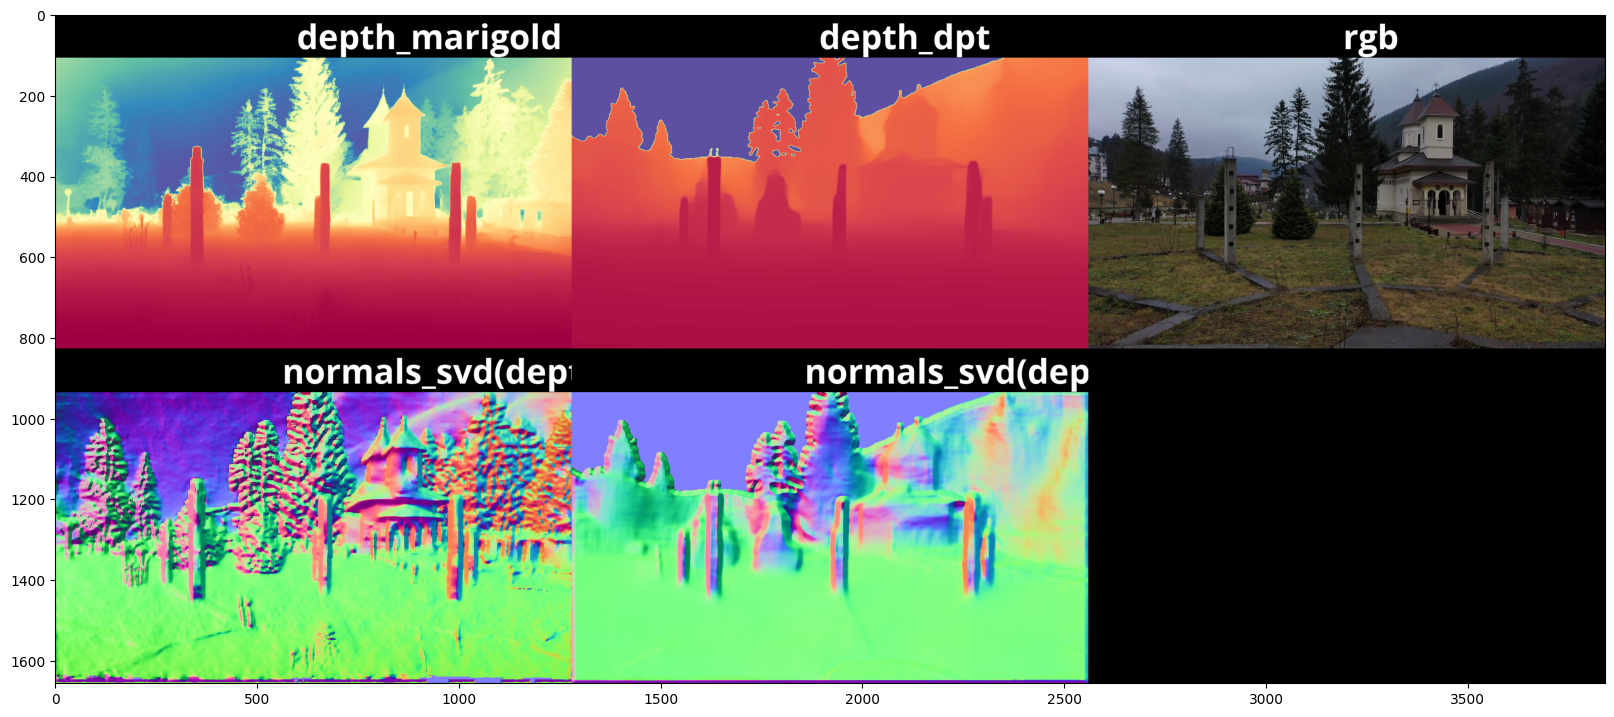

In [13]:
frames = [x.name for x in Path(output_dir / "rgb/png").iterdir()]
start_frame = np.random.permutation(frames)[0]
imgs = [image_read(output_dir / r / "png" / start_frame) for r in vre.representations]
collage = collage_fn(imgs, titles=vre.representations, size_px=70, rows_cols=None)
image_write(collage, f"collage_{start_frame}")
plt.figure(figsize=(20, 10))
plt.imshow(collage)